In [388]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt

# 1. Get Data For New Delhi

In [257]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Delhi").text
soup = BeautifulSoup(data, 'html.parser')
neighborhoodList = []
for group in soup.find_all("div", class_="mw-category-group"):
    for row in group.findAll("li"):
        text = row.text
        if text in ['Neighbourhoods of Delhi', 'Vikram Vihar', 'Haqiqat Nagar']:
            continue
        neighborhoodList.append(text)
nd_df = pd.DataFrame({"Neighborhood": neighborhoodList})
nd_df

,Neighborhood
0,Ashok Nagar (Delhi)
1,Ashok Vihar
2,Ashram Chowk
3,Babarpur
4,"Badarpur, Delhi"
...,...
145,Vikaspuri
146,Vivek Vihar subdivision
147,West Patel Nagar
148,Yamuna Pushta


# 2. Get Coordinates and Create a Map

In [258]:
def get_latlng(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Delhi, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [259]:
coords = [ get_latlng(neighborhood) for neighborhood in nd_df["Neighborhood"].tolist() ]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
nd_df['Latitude'] = df_coords['Latitude']
nd_df['Longitude'] = df_coords['Longitude']
nd_df

,Neighborhood,Latitude,Longitude
0,Ashok Nagar (Delhi),28.692230,77.301240
1,Ashok Vihar,28.690370,77.176090
2,Ashram Chowk,28.710598,77.326965
3,Babarpur,28.507380,77.303460
4,"Badarpur, Delhi",28.507380,77.303460
...,...,...,...
145,Vikaspuri,28.644640,77.075110
146,Vivek Vihar subdivision,28.646420,77.306150
147,West Patel Nagar,28.647830,77.164490
148,Yamuna Pushta,28.656300,77.215560


In [260]:
nd_df.to_csv("nd_df.csv", index=False)

In [261]:
address = 'Delhi, India'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi, India {}, {}.'.format(latitude, longitude))
map_nd = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, neighborhood in zip(nd_df['Latitude'], nd_df['Longitude'], nd_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_nd)  
map_nd

The geograpical coordinate of Delhi, India 28.6517178, 77.2219388.


In [262]:
# save the map as HTML file
map_nd.save('map_nd.html')

# 3. Connect to FourSquare

In [450]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


# Listing top 10 venues that are within a radius of 500 meters.

In [264]:
radius = 500
LIMIT = 10
venues = []
for lat, long, neighborhood in zip(nd_df['Latitude'], nd_df['Longitude'], nd_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [265]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head()

(715, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Ashok Nagar (Delhi),28.69223,77.30124,Neeraj Kumar Garg,28.692731,77.298772,Spa
1,Ashok Nagar (Delhi),28.69223,77.30124,Axis Bank ATM,28.696470,77.299910,ATM
2,Ashok Vihar,28.69037,77.17609,Domino's Pizza,28.693000,77.177000,Pizza Place
3,Ashok Vihar,28.69037,77.17609,Sagar Ratna | सागर रतना,28.693381,77.177977,South Indian Restaurant
4,Ashok Vihar,28.69037,77.17609,Central park,28.690427,77.175620,Garden


In [266]:
venues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Ashok Nagar (Delhi),2,2,2,2,2,2
Ashok Vihar,4,4,4,4,4,4
Babarpur,3,3,3,3,3,3
"Badarpur, Delhi",3,3,3,3,3,3
Bali Nagar,7,7,7,7,7,7
...,...,...,...,...,...,...
Vasundhara Enclave,4,4,4,4,4,4
Vikaspuri,2,2,2,2,2,2
Vivek Vihar subdivision,4,4,4,4,4,4


In [267]:
venues_df['VenueCategory'].unique()[:50]

array(['Spa', 'ATM', 'Pizza Place', 'South Indian Restaurant', 'Garden',
       'Market', 'Indian Restaurant', 'Chinese Restaurant',
       'Dessert Shop', 'Light Rail Station', 'Shoe Store',
       'Fast Food Restaurant', 'Shopping Mall', 'Café',
       'Airport Food Court', 'Hotel', 'History Museum', 'Clothing Store',
       'Flea Market', 'Snack Place', 'Food Service', "Women's Store",
       'Plaza', 'Ice Cream Shop', 'Bakery', 'Lounge',
       'Molecular Gastronomy Restaurant', 'Coffee Shop', 'Mosque',
       'Museum', 'Paper / Office Supplies Store', 'Nightclub',
       'Electronics Store', 'Business Service', 'Indie Movie Theater',
       'Hot Dog Joint', 'Restaurant', 'Italian Restaurant',
       'Cocktail Bar', 'Donut Shop', 'Gym Pool', 'Golf Course',
       'Metro Station', 'BBQ Joint', 'Flower Shop', 'Diner', 'Arcade',
       'Sandwich Place', 'Train Station', 'Asian Restaurant'],
      dtype=object)

# 4. Hot Encoding Venues

In [268]:
nd_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")
nd_onehot['Neighborhood'] = venues_df['Neighborhood'] 
fixed_columns = [nd_onehot.columns[-1]] + list(nd_onehot.columns[:-1])
nd_onehot = nd_onehot[fixed_columns]
print(nd_onehot.shape)
nd_onehot.head()
nd_grouped = nd_onehot.groupby(["Neighborhood"]).mean().round(2).reset_index()
print(nd_grouped.shape)
nd_grouped

(715, 139)
(138, 139)


,Neighborhood,Yoga Studio,ATM,Accessories Store,Afghan Restaurant,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Art Gallery,...,Tea Room,Temple,Thai Restaurant,Theater,Tibetan Restaurant,Trail,Train Station,University,Water Park,Women's Store
0,Ashok Nagar (Delhi),0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,Ashok Vihar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,Babarpur,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,"Badarpur, Delhi",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,Bali Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,Vasundhara Enclave,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
134,Vikaspuri,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
135,Vivek Vihar subdivision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0
136,West Patel Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


# Finding the Top 10 most Popular Restaurants

In [383]:
total = nd_onehot.groupby(["Neighborhood"]).sum().reset_index()

In [385]:
rest = [col for col in venues_df['VenueCategory'].unique() if 'restaurant' in col.lower()]
rest

['South Indian Restaurant',
 'Indian Restaurant',
 'Chinese Restaurant',
 'Fast Food Restaurant',
 'Molecular Gastronomy Restaurant',
 'Restaurant',
 'Italian Restaurant',
 'Asian Restaurant',
 'Thai Restaurant',
 'Japanese Restaurant',
 'Korean Restaurant',
 'Mexican Restaurant',
 'Northeast Indian Restaurant',
 'Afghan Restaurant',
 'English Restaurant',
 'Modern European Restaurant',
 'French Restaurant',
 'Tibetan Restaurant',
 'North Indian Restaurant',
 'Portuguese Restaurant',
 'Middle Eastern Restaurant',
 'American Restaurant',
 'Mughlai Restaurant',
 'Australian Restaurant',
 'Mediterranean Restaurant']

In [439]:
ranks = total[rest].sum()
ranks.sort_values(ascending=False, inplace=True)
ranks = ranks[(ranks.values > 1) & ~(ranks.index.isin(['Restaurant']))]

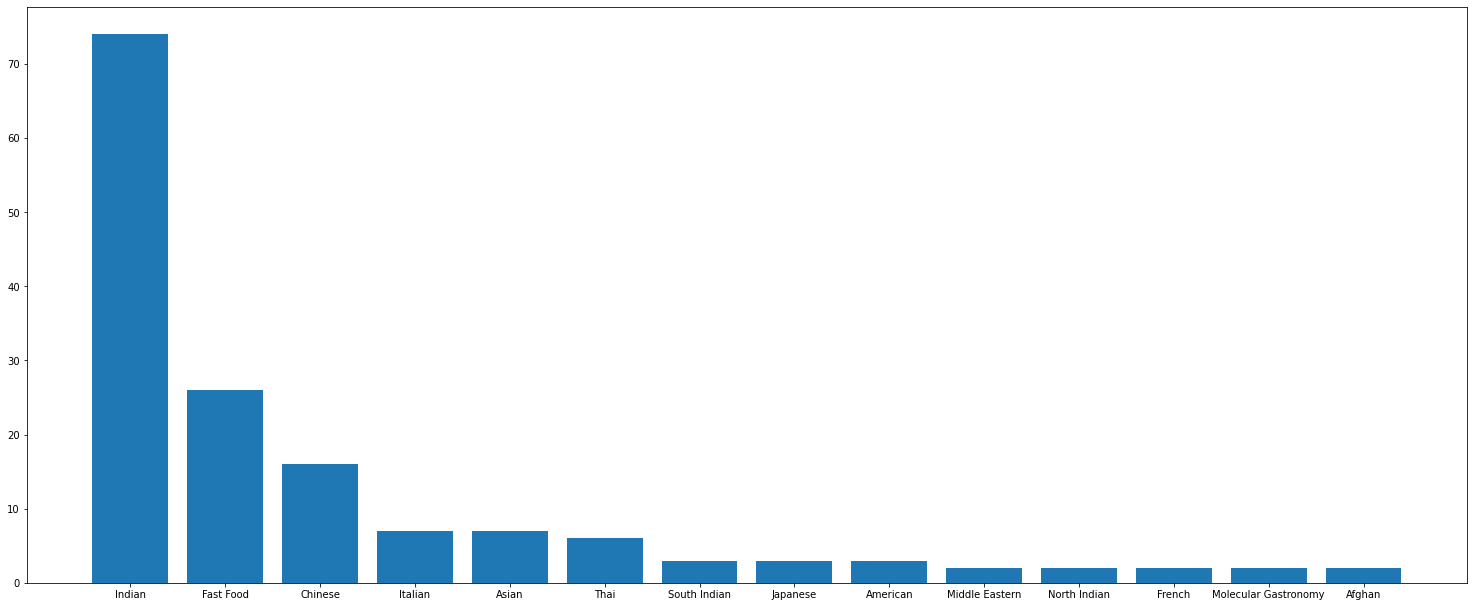

In [449]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_axes([0,0,1,1])
ax.bar([" ".join([ph for ph in name.split() if ph.lower() != 'restaurant']) for name in ranks.index.tolist()], ranks.values.tolist())
plt.show()

In [443]:
top_10_rest = ranks.index[:10].tolist()
top_10_rest

['Indian Restaurant',
 'Fast Food Restaurant',
 'Chinese Restaurant',
 'Italian Restaurant',
 'Asian Restaurant',
 'Thai Restaurant',
 'South Indian Restaurant',
 'Japanese Restaurant',
 'American Restaurant',
 'Middle Eastern Restaurant']

In [324]:
nd_rest = nd_grouped[['Neighborhood']+top_10_rest]

# 5. Clustering Based on The number of A paritcular type of Restaurant

In [325]:
kclusters = 10
nd_clustering = nd_rest.drop(["Neighborhood"], 1)
rest_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nd_clustering)
rest_kmeans.labels_[0:10] 

array([2, 2, 2, 2, 1, 5, 6, 2, 0, 2])

In [330]:
nd_rest_merged = nd_rest.copy()
nd_rest_merged = nd_rest_merged.join(nd_df.set_index("Neighborhood"), on="Neighborhood")
nd_rest_merged["Cluster Labels"] = rest_kmeans.labels_
nd_rest_merged.head()

,Neighborhood,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,Asian Restaurant,Thai Restaurant,South Indian Restaurant,Japanese Restaurant,American Restaurant,Middle Eastern Restaurant,Latitude,Longitude,Cluster Labels
0,Ashok Nagar (Delhi),0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,28.69223,77.301240,2
1,Ashok Vihar,0.00,0.0,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.0,28.69037,77.176090,2
2,Babarpur,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,28.50738,77.303460,2
3,"Badarpur, Delhi",0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,28.50738,77.303460,2
4,Bali Nagar,0.14,0.0,0.14,0.0,0.0,0.0,0.00,0.0,0.0,0.0,28.65223,77.129411,1


In [332]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(nd_rest_merged['Latitude'], nd_rest_merged['Longitude'], nd_rest_merged['Neighborhood'], nd_rest_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        tooltip=cluster).add_to(map_clusters)   
map_clusters

In [304]:
map_clusters.save('rest_map_clusters.html')

# 6. Clustering Based on Location

In [333]:
kclusters = 4
nd_clustering = nd_df.drop(["Neighborhood"], 1)
loc_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nd_clustering)
loc_kmeans.labels_[0:10] 

array([3, 0, 3, 1, 1, 0, 0, 1, 3, 1])

In [334]:
nd_loc_merged = nd_df.copy()
nd_loc_merged["Cluster Labels"] = loc_kmeans.labels_
nd_loc_merged.sort_values(["Cluster Labels"], inplace=True)
nd_loc_merged

,Neighborhood,Latitude,Longitude,Cluster Labels
51,Kathputli Colony,28.65346,77.152860,0
75,Model Town (Delhi),28.70501,77.189500,0
50,Karol Bagh,28.65045,77.188730,0
21,Derawal Nagar,28.69911,77.191050,0
47,"Kamla Nagar, New Delhi",28.68376,77.201630,0
...,...,...,...,...
92,Nizamuddin East,28.60124,77.264521,3
95,Old Delhi,28.65434,77.232580,3
97,Palika Bazaar,28.63156,77.219590,3
103,Preet Vihar,28.63903,77.295970,3


In [335]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(nd_loc_merged['Latitude'], nd_loc_merged['Longitude'], nd_loc_merged['Neighborhood'], nd_loc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        tooltip=cluster).add_to(map_clusters)  
map_clusters

# 7. Creating a guide by merge the Label Information for the 2 Clustering

In [367]:
nd_rest = nd_rest_merged[['Neighborhood', 'Cluster Labels']]
nd_rest.columns = ['Neighborhood', 'Restaurant Region']
loc_nd = nd_loc_merged[['Neighborhood', 'Cluster Labels']]
loc_nd.columns = ['Neighborhood', 'Region']
info_guide = pd.merge(nd_rest, loc_nd, on='Neighborhood')
info_guide = pd.merge(info_guide, nd_df, on='Neighborhood')

# 8. Based on Your Current Location, you Region will be determined and it will provide you the similar neighborhoods in the other 3 Regions of Delhi

In [368]:
def find_closest_neighbor(your_location, nd_df):
    lat, long = get_latlng(your_location)
    closest_neighbor = None
    for neighbor, n_lat, n_long in nd_df.values:
        distance = pow(pow(lat - n_lat,2) + pow(long - n_long,2), 0.5)
        if not closest_neighbor:
            closest_neighbor = (neighbor, distance)
        else:
            closest_neighbor = min(closest_neighbor, (neighbor, distance), key=lambda x: x[1])
    return closest_neighbor

In [379]:
your_location = "ashok vihar"

In [380]:
neighbor = find_closest_neighbor(your_location, nd_df)[0]
neighborhood, rest, loc, lat, long = info_guide[info_guide.Neighborhood == neighbor].values[0]
similar_loc = info_guide[(info_guide['Restaurant Region'] == rest) & (info_guide['Region'] != loc) | (info_guide.Neighborhood == neighbor)]

In [381]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(similar_loc['Latitude'], similar_loc['Longitude'], similar_loc['Neighborhood'], similar_loc['Region']):
    label = folium.Popup(str(poi) + ' - Region ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        tooltip=cluster).add_to(map_clusters)      
map_clusters